In [ ]:
# Downloding the data

import zipfile

!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip")
zip_ref.extractall()
zip_ref.close()

--2021-07-07 09:50:21--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.73.240, 142.250.65.80, 142.250.188.208, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.73.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   174MB/s    in 0.9s    

2021-07-07 09:50:22 (174 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import os

In [ ]:
train_dir = "/content/10_food_classes_10_percent/train"
test_dir = "/content/10_food_classes_10_percent/test"

train_datagen = ImageDataGenerator(rescale=1/255.)                
test_datagen = ImageDataGenerator(rescale=1/255.)
                                  

train_data = train_datagen.flow_from_directory(train_dir,
                                               target_size = (224, 224),
                                               class_mode = "categorical",
                                               batch_size = 32)

test_data = test_datagen.flow_from_directory(test_dir,
                                             target_size = (224, 224),
                                             class_mode = "categorical",
                                             batch_size = 32)

Found 750 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


In [ ]:
for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent/tes

# Setting up Callbacks

In [ ]:
# Create a TensorBoard callback (we'll functionize this callback as we'll use it later on again and again)

import datetime

def create_tensorboard_callback(dir_name, experiment_name):
  
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir)
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

## Creating models using TensorFlow Hub

In [ ]:
# Comparing Resnet and Efficientnet models

resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5"
efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

In [ ]:
# Import dependencies

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [ ]:
# Making a create_model() function to create a model from a URL

def create_model(model_url, num_classes = 10):
  """
  Takes a TensorFlow Hub URL and creates a Keras Sequential model with it.
  Args:
    model_url (str): A TensorFlow Hub feature extraction URL.
    num_classes (int): Number of output neurons in the output layer, should be equal to the number of target classes, default 10.
  Returns:
    An uncompiled Keras Sequential model with model_url as feature extractor layer and Dense output layer with num_classes output neurons.
  """
  # Download the pretrained model and save it as a Keras layer

  feature_extraction_layer = hub.KerasLayer(model_url,
                                           trainable=False, #Freeze the already learned patterns.
                                           name = "feature_extraction_layer",
                                           input_shape = IMAGE_SHAPE+(3,)) 
  
  # Creating the model
  model = tf.keras.models.Sequential([
    feature_extraction_layer,
    layers.Dense(num_classes, activation="softmax", name = "output_layer")
  ])

  return model

# Creating and testing ResNet TensorFlow Hub Feature Extraction model

In [ ]:
# Create Resnet model

IMAGE_SHAPE = (224, 224)
resnet_model = create_model(resnet_url, 10)

In [ ]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
feature_extraction_layer (Ke (None, 2048)              23564800  
_________________________________________________________________
output_layer (Dense)         (None, 10)                20490     
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [ ]:
# Compiling the model

resnet_model.compile(loss = tf.keras.losses.categorical_crossentropy,
                     optimizer = tf.keras.optimizers.Adam(),
                     metrics = ["accuracy"])

In [ ]:
# Fitting the model

history = resnet_model.fit(train_data, epochs=5, steps_per_epoch=len(train_data), validation_data=test_data, validation_steps=len(test_data), callbacks=[create_tensorboard_callback("history", "model")])

Saving TensorBoard log files to: history/model/20210706-193613
Epoch 1/5
24/24 [==============================] - 17s 707ms/step - loss: 0.1446 - accuracy: 0.9907 - val_loss: 0.6232 - val_accuracy: 0.7980
Epoch 2/5
24/24 [==============================] - 16s 671ms/step - loss: 0.1255 - accuracy: 0.9933 - val_loss: 0.6234 - val_accuracy: 0.7968
Epoch 3/5
24/24 [==============================] - 16s 669ms/step - loss: 0.1128 - accuracy: 0.9973 - val_loss: 0.6181 - val_accuracy: 0.7984
Epoch 4/5
24/24 [==============================] - 15s 659ms/step - loss: 0.0993 - accuracy: 0.9973 - val_loss: 0.6158 - val_accuracy: 0.8020
Epoch 5/5
24/24 [==============================] - 15s 658ms/step - loss: 0.0894 - accuracy: 0.9973 - val_loss: 0.6160 - val_accuracy: 0.7972


<Figure size 432x288 with 0 Axes>

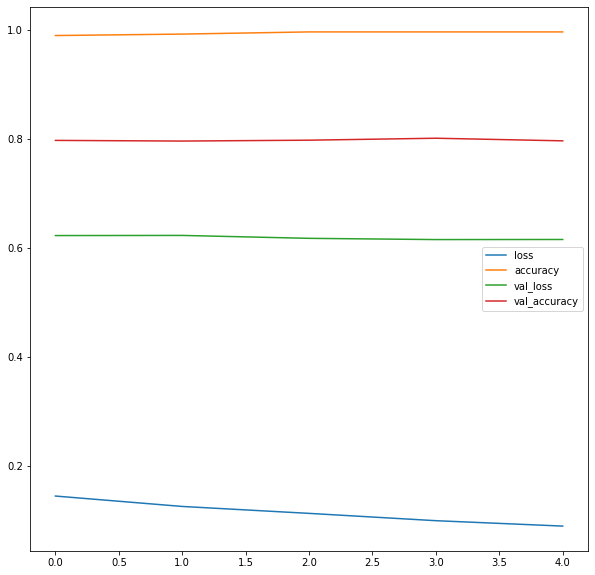

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

plt.figure()
pd.DataFrame(history.history).plot(figsize = (10,10))

In [ ]:
# Function to plot the loss curves

def plot_loss_curves(history):
  
  loss = history.history["loss"]
  val_loss = history.history["val_loss"]
  accuracy = history.history["accuracy"]
  val_accuracy = history.history["val_accuracy"]
  epochs = range(len(history.history["loss"]))

  # Plot loss
  plt.figure()
  plt.plot(epochs, loss, label="training loss")
  plt.plot(epochs, val_loss, label="validation loss")
  plt.title("loss")
  plt.xlabel("epochs")
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label="training accuracy")
  plt.plot(epochs, val_accuracy, label="validation accuracy")
  plt.title("accuracy")
  plt.xlabel("epochs")
  plt.legend

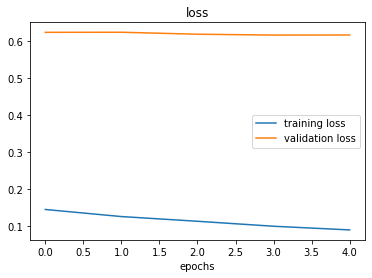

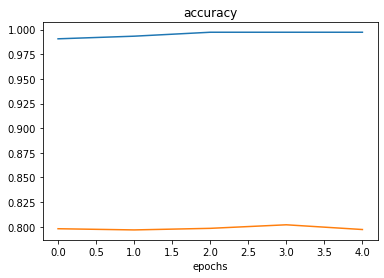

In [ ]:
plot_loss_curves(history)

# Creating and testing EfficientNet TensorFlow Hub Feature Extraction model

In [ ]:
model_efficientNet = create_model(efficientnet_url, 10)

In [ ]:
model_efficientNet.compile(loss = tf.keras.losses.categorical_crossentropy,
                           optimizer = tf.keras.optimizers.Adam(),
                           metrics = ["accuracy"])

In [ ]:
history_efficientNet = model_efficientNet.fit(train_data,
                                             epochs = 5,
                                             steps_per_epoch = len(train_data),
                                             validation_data = test_data,
                                             validation_steps = len(test_data),
                                             callbacks = [create_tensorboard_callback("efficient_net_history",
                                                                                      "model_efficientNet")])

# EfficientNet outperformed ResNet!!!

Saving TensorBoard log files to: efficient_net_history/model_efficientNet/20210706-195303
Epoch 1/5
24/24 [==============================] - 16s 688ms/step - loss: 0.3953 - accuracy: 0.9147 - val_loss: 0.4962 - val_accuracy: 0.8696
Epoch 2/5
24/24 [==============================] - 15s 627ms/step - loss: 0.3533 - accuracy: 0.9307 - val_loss: 0.4760 - val_accuracy: 0.8676
Epoch 3/5
24/24 [==============================] - 15s 626ms/step - loss: 0.3177 - accuracy: 0.9413 - val_loss: 0.4594 - val_accuracy: 0.8752
Epoch 4/5
24/24 [==============================] - 15s 636ms/step - loss: 0.2864 - accuracy: 0.9520 - val_loss: 0.4459 - val_accuracy: 0.8732
Epoch 5/5
24/24 [==============================] - 15s 626ms/step - loss: 0.2623 - accuracy: 0.9640 - val_loss: 0.4364 - val_accuracy: 0.8768


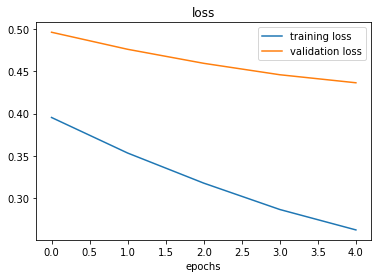

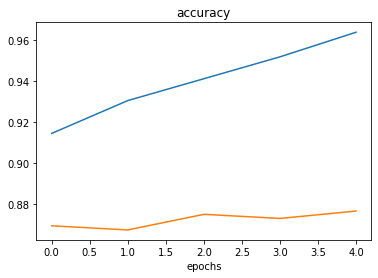

In [ ]:
plot_loss_curves(history_efficientNet)

# Comparing our models' results using TensorBoard

In [ ]:
# Upload TensorBoard dev records

!tensorboard dev upload --logdir ./histories/ \
  --name "EfficientNetB0 vs. ResNet50v2" \
  --description "Comparing two different TF Hub feature extraction models architectures." \
  --one_shot

2021-07-06 20:39:51.533858: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0

***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./histories/

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=373649185512-8v619h5kft38l4456nm2dj4ubeqsrvh6.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3A

Our experiments' results' link on tensorboard: https://tensorboard.dev/experiment/ugEoEMKSRRaWuZ9EMF6Wdw/

In [ ]:
# Chesck out what TensorBoard experiments we have

!tensorboard dev list

2021-07-06 20:48:57.988714: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
Data for the "text" plugin is now uploaded to TensorBoard.dev! Note that uploaded data is public. If you do not want to upload data for this plugin, use the "--plugins" command line argument.
https://tensorboard.dev/experiment/ugEoEMKSRRaWuZ9EMF6Wdw/
	Name                 EfficientNetB0 vs. ResNet50v2
	Description          Comparing two different TF Hub feature extraction models architectures.
	Id                   ugEoEMKSRRaWuZ9EMF6Wdw
	Created              2021-07-06 20:41:27 (7 minutes ago)
	Updated              2021-07-06 20:41:32 (7 minutes ago)
	Runs                 9
	Tags                 5
	Scalars              120
	Tensor bytes         0
	Binary object bytes  16108103
Total: 1 experiment(s)


In [ ]:
# Deleting an experiment
"""
!tensorboard dev delete --experiment_id (yukarıdali dev listte yer alan silmek istediğimiz experiment ın (id)'sini (örn:ugEoEMKSRRaWuZ9EMF6Wdw) kopyalayıp yapıştırıyoruz)
"""

"\n!tensorboard dev delete --experiment_id (yukarıdali dev listte yer alan silmek istediğimiz experiment ın (id)'sini (örn:ugEoEMKSRRaWuZ9EMF6Wdw) kopyalayıp yapıştırıyoruz)\n"

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub

In [ ]:
mobileNet_url = "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/5"

feature_extraction_layer = hub.KerasLayer(mobileNet_url,
                                          trainable = False,
                                          input_shape = (224,224,3))

In [ ]:
mobileNet_model = tf.keras.Sequential([feature_extraction_layer,
                                       tf.keras.layers.Dense(10, activation="softmax")])

mobileNet_model.compile(loss = tf.keras.losses.categorical_crossentropy,
                        optimizer = tf.keras.optimizers.Adam(),
                        metrics = ["accuracy"])

mobileNet_history = mobileNet_model.fit(train_data,
                                        epochs = 5,
                                        steps_per_epoch = len(train_data),
                                        validation_data = test_data,
                                        validation_steps = len(test_data),
                                        callbacks = [create_tensorboard_callback(dir_name = "histories",
                                                                                 experiment_name = "mobileNet")])

Saving TensorBoard log files to: histories/mobileNet/20210707-095349
Epoch 1/5
24/24 [==============================] - 48s 681ms/step - loss: 2.0292 - accuracy: 0.3173 - val_loss: 1.3803 - val_accuracy: 0.5540
Epoch 2/5
24/24 [==============================] - 14s 601ms/step - loss: 1.0749 - accuracy: 0.6987 - val_loss: 0.9140 - val_accuracy: 0.7312
Epoch 3/5
24/24 [==============================] - 14s 596ms/step - loss: 0.7455 - accuracy: 0.8027 - val_loss: 0.7777 - val_accuracy: 0.7640
Epoch 4/5
24/24 [==============================] - 14s 597ms/step - loss: 0.6043 - accuracy: 0.8427 - val_loss: 0.7095 - val_accuracy: 0.7880
Epoch 5/5
24/24 [==============================] - 14s 596ms/step - loss: 0.4983 - accuracy: 0.8813 - val_loss: 0.6696 - val_accuracy: 0.7952


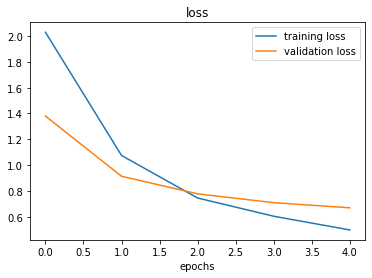

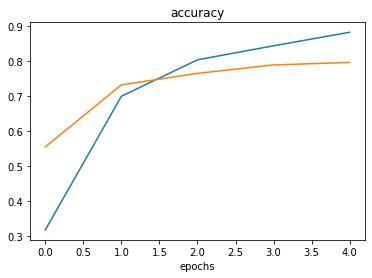

In [ ]:
plot_loss_curves(mobileNet_history)